# Einlesen der FACT Daten


Die Daten sind im HDF5 Format gespeichert und können mit dem Python-Modul h5py eingelesen werden.

Das Python-Modul `pyfact` bietet eine nützliche Funktion, um diese Daten direkt in ein `pandas.DataFrame` einzulesen.

```
$ pip install pyfact
```

In [167]:
from fact.io import read_h5py
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Einlesen mit h5py

In [168]:
f = h5py.File('../data/open_crab_sample_dl3.hdf5')

print('Tables:')
print(*f)

print()
print('Columns in events table')
print(*f['events'])

print()
print('Columns in runs table')
print(*f['runs'])
f.close()

Tables:
events runs

Columns in events table
dec_prediction disp_prediction event_num gamma_energy_prediction gamma_prediction index night pointing_position_az pointing_position_zd ra_prediction run_id theta_deg theta_deg_off_1 theta_deg_off_2 theta_deg_off_3 theta_deg_off_4 theta_deg_off_5 timestamp

Columns in runs table
azimuth declination index night ontime right_ascension run_id run_start run_stop source zenith


In [169]:
#theta_deg = f['events/theta_deg'][:]

#plt.hist(theta_deg**2, bins=30, range=[0, 0.1])
#None

## Daten einlesen mit pyfact

In [170]:
gammas = read_h5py('../data/gamma_test_dl3.hdf5', key='events', columns=[
    'gamma_energy_prediction',
    'gamma_prediction',
    'theta_deg',
    'corsika_event_header_event_number',
    'corsika_event_header_total_energy',
])
#Testdatensatz aus simulierten Daten


gammas_corsika = read_h5py(
    '../data/gamma_corsika_events_1.1.2.hdf5',
    key='corsika_events',
    columns=['total_energy'],
)
# Infos über simulierten Daten


crab_events = read_h5py('../data/open_crab_sample_dl3.hdf5', key='events', columns=[
    'gamma_prediction',
    'gamma_energy_prediction',
    'theta_deg',
    'theta_deg_off_1',
    'theta_deg_off_2',
    'theta_deg_off_3',
    'theta_deg_off_4',
    'theta_deg_off_5',
])
#Messdaten

crab_runs = read_h5py('../data/open_crab_sample_dl3.hdf5', key='runs')

In [171]:
#crab_events.head()

# Limits für theata^2 - Plot

In [172]:
limit_theta = np.sqrt(0.025)
crab_events_pred = crab_events[crab_events.gamma_prediction>0.8]
crab_events_sel = crab_events_pred[crab_events_pred.theta_deg<limit_theta]

gammas_pred = gammas[gammas.gamma_prediction>0.8]
gammas_sel = gammas_pred[gammas_pred.theta_deg < limit_theta]

In [173]:
# Mit diesem limit werden alle events für den theta^2 plot ausgewählt (theta^2 < 0.3)
# Für Berechnungen weiterhin crab_events_sel bzw bkg verwenden
limit_theta_plot = np.sqrt(0.3)
crab_events_pred_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta_plot]
crab_events_pred_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta_plot]
crab_events_pred_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta_plot]
crab_events_pred_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta_plot]
crab_events_pred_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta_plot]

crab_events_sel_plot= crab_events_pred[crab_events_pred.theta_deg < limit_theta_plot]

In [174]:
crab_events_sel_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta]
crab_events_sel_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta]
crab_events_sel_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta]
crab_events_sel_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta]
crab_events_sel_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta]
# mask = (crab_events_pred.theta_deg_off_1 < limit_theta) | (crab_events_pred.theta_deg_off_2 < limit_theta) | (crab_events_pred.theta_deg_off_3 < limit_theta) | (crab_events_pred.theta_deg_off_4 < limit_theta) | (crab_events_pred.theta_deg_off_5 < limit_theta)
# crab_events_sel_all = crab_events_pred[mask]
bkg = pd.concat([crab_events_sel_1, crab_events_sel_2, crab_events_sel_3, crab_events_sel_4, crab_events_sel_5])

# Histogramm der Abstandswinkel

In [175]:
theta_deg_off = []
for i in [1, 2, 3, 4, 5]:
    exec('x = crab_events_pred_{}.theta_deg_off_{}.values'.format(i, i))
    for el in x:
        theta_deg_off.append(el)

250


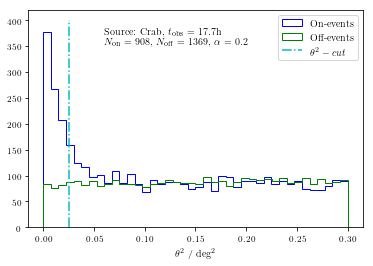

In [176]:
crab_events_sel_on = np.array(crab_events_sel_plot.theta_deg.values)
plt.hist((crab_events_sel_on)**2, bins =40, histtype='step', color='blue', label='On-events')

plt.hist(np.array(theta_deg_off)**2, bins=40, histtype='step', color='g', label='Off-events', weights=np.array([0.2 for el in theta_deg_off]))
plt.vlines(0.025, color='c', linestyle='-.', ymin=0, ymax=400, label=r'$\theta^{2}-cut$')
plt.xlabel(r'$\theta^2$ / $\deg^2$')
plt.legend()
plt.text(0.06, 350,
         r'''Source: Crab, $t_\mathrm{{obs}}$ = 17.7h
        $N_\mathrm{{on}}$ = {non}, $N_\mathrm{{off}}$ = {noff}, $\alpha$ = 0.2'''.format(non=len(crab_events_sel), noff=len(bkg)))

print(len(crab_events_sel_1.theta_deg_off_1.values))

# 2D-Scatterplot der Energien

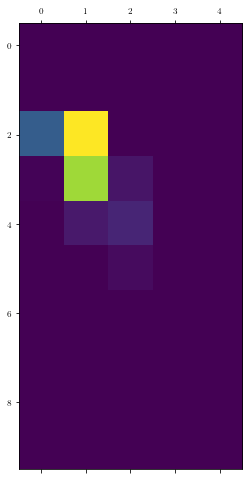

In [234]:
matrix, xedge, yedge = np.histogram2d(
    gammas_sel['gamma_energy_prediction'],
    gammas_sel['corsika_event_header_total_energy'], 
                                         bins=[
                                             np.logspace(np.log10(200),np.log10(50e3),11),
                                             np.logspace(np.log10(200),np.log10(50e3),6),
                                         ],
                                         normed='True')
plt.matshow(matrix)
#plt.xscale('log')
#plt.yscale('log')
#plt.gca().set_aspect(1)

Text(0, 0.5, 'gamma\\_true\\_energy')

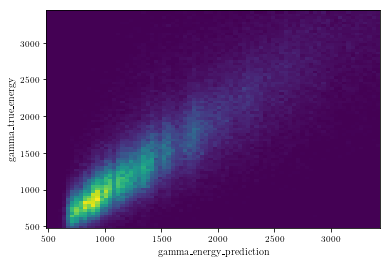

In [198]:
# definiere Grenzquantile für plot
up = np.quantile(gammas['corsika_event_header_total_energy'], 0.9)
low = np.quantile(gammas['corsika_event_header_total_energy'], 0.1)

plt.hist2d(gammas_sel['gamma_energy_prediction'],
                                         gammas_sel['corsika_event_header_total_energy'], 
                                         bins=80, 
                                         normed='True',
                                         range=[[low, up],[low, up]])
#plt.xscale('log')#
#plt.yscale('log')
plt.xlabel('gamma\_energy\_prediction') 
plt.ylabel('gamma\_true\_energy')

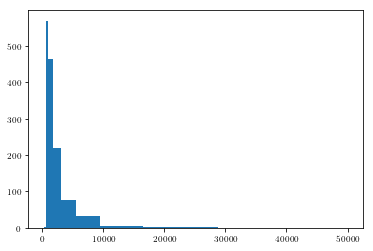

In [235]:
# Untergrund binnen
b, bins, p = plt.hist(bkg['gamma_energy_prediction'], bins=xedge)

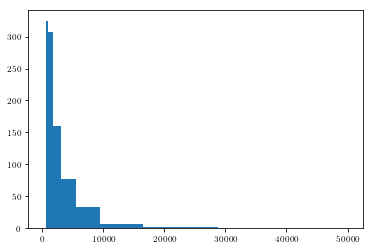

In [236]:
# Signal binnen
g, bins, p = plt.hist(crab_events_sel['gamma_energy_prediction'], bins=xedge)

In [237]:
print(matrix)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.39406362e-10 2.31027988e-11 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.08789784e-07 3.69237414e-07 9.61034738e-10 0.00000000e+00
  0.00000000e+00]
 [4.25091497e-09 3.17005242e-07 2.13672731e-08 1.93476591e-11
  0.00000000e+00]
 [7.98034827e-11 2.51632398e-08 3.86926943e-08 1.63206139e-10
  0.00000000e+00]
 [0.00000000e+00 3.62931471e-10 1.08237535e-08 7.18500388e-10
  4.62055975e-13]
 [0.00000000e+00 4.38344787e-12 5.36594664e-10 8.90703815e-10
  5.10742289e-12]
 [0.00000000e+00 0.00000000e+00 3.62456540e-12 1.83713456e-10
  1.48245646e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.17146933e-12
  1.12855456e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.59875402e-13]]


In [238]:
# Penrose-Moore Pseudoinverse ausrechnen wegen Singularität
inv = np.linalg.pinv(matrix)
print(inv)

[[ 5.65857263e-10  3.63623312e+04  9.64533306e+06 -1.17154585e+07
   6.04797938e+06  7.24102843e+05 -1.47760949e+06  1.79425628e+05
   4.01957628e+05  2.42205799e+04]
 [-1.68103121e-10 -7.14895312e+03 -1.33732917e+05  3.45749632e+06
  -1.85143690e+06 -2.17472977e+05  4.51753982e+05 -5.49469566e+04
  -1.22932587e+05 -7.40734172e+03]
 [ 1.34366716e-09  2.63694922e+04  6.60250212e+04 -2.18977072e+06
   2.65903845e+07  1.97836017e+06 -6.60449356e+06  8.31067596e+05
   1.80989748e+06  1.09009579e+05]
 [ 5.75797351e-08 -2.63251702e+05 -4.06750903e+05  1.37011766e+07
  -1.74873259e+08  5.62225310e+08  7.24865652e+08 -1.09120529e+08
  -2.06999573e+08 -1.24380239e+07]
 [ 1.31944511e-06  4.85754217e+06  7.04063160e+06 -2.37341354e+08
   3.03610749e+09 -1.03459961e+10 -1.08065562e+09  4.18746904e+10
   3.43974581e+10  2.01805019e+09]]


In [239]:
np.shape(yedge)

(6,)

Unfolded: [-8.75875512e+08 -4.02152617e+08 -1.26960532e+09  8.83627239e+09
 -7.12048352e+10]
 shape (5,)


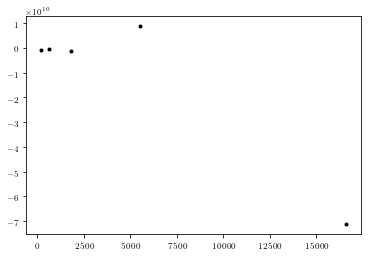

In [240]:
# Naive Entfaltung
ev = g-b
print('Unfolded: {}\n shape {}'.format(inv.dot(ev), np.shape(inv.dot(ev))))
plt.plot(yedge[:-1], inv.dot(ev), 'k.')

In [ ]:
äquidistanz im logspace, numpy histogram2d, mathshow